In [1]:
import os
import pandas as pd
import random

import sys
sys.path.insert(0, '..')

from unpast.run_unpast import run
from unpast.utils.method import prepare_input_matrix, make_consensus_biclusters

### Input and output

This example uses expressions of 200 randomly chosen samples from the TCGA-BRCA dataset (normalized and standardized log2(x+1) RNA-seq counts)

In [2]:
# input .tsv file; features in rows, samples in columns
exprs_file = "test_data_TCGA200/TCGA_200.exprs_z.tsv" 

if not os.path.exists(exprs_file):
    from gdown import download
    from zipfile import ZipFile

    url = 'https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN'
    output = 'test_data_TCGA200.zip'
    download(url, output, quiet=False)

    with ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()

    os.remove(output)

# or download and unzip it manually: https://drive.google.com/file/d/1zee_GssqXCv_-tokLRJKR8cLksxsa8UN/view?usp=drive_link# input .tsv file; features in rows, samples in columns

In [3]:
# specify output folder and output file prefix
basename = 'TCGA200'
out_dir = "test_results/"

### Run UnPaSt 

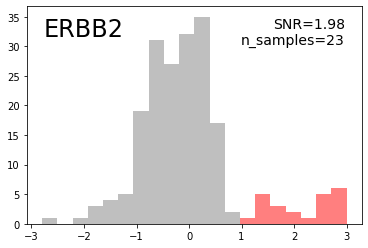

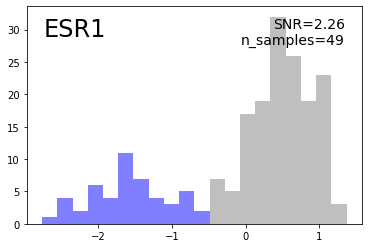

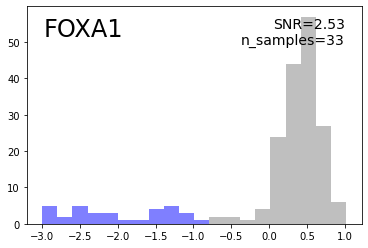

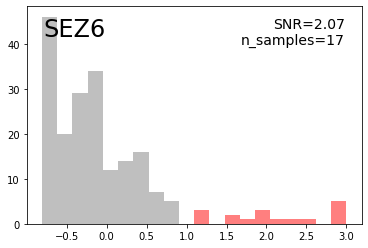

In [ ]:
results = run(exprs_file,
            basename,
            out_dir=out_dir,
            # optional: show distributions of some selected features
            # known subtype-specific biomarkers are chosen in this example
            show_fits = ["ERBB2","ESR1","FOXA1","SEZ6"],
            seed = 42,
            verbose = False
            )

In [5]:
results.head(2)

SNR n_genes n_samples  \
0  3.528302      39        37   
1  2.453225     157        38   

                                               genes  \
0  {EEF1A2, CA8, CAPN13, XBP1, FOXA1, FBP1, TFF1,...   
1  {INA, GSTA2, NR2E1, UNC80, ZBTB8B, CLDN6, PRAM...   

                                             samples direction  \
0  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...      DOWN   
1  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...        UP   

                                            genes_up  \
0                                                 {}   
1  {INA, GSTA2, NR2E1, UNC80, ZBTB8B, RBM38, PRAM...   

                                          genes_down  \
0  {EEF1A2, CA8, XBP1, CAPN13, FOXA1, FBP1, TFF1,...   
1                                                 {}   

                                        gene_indexes  \
0  {1923, 388, 9990, 3847, 7176, 11795, 11159, 38...   
1  {9729, 7681, 12290, 3077, 1035, 7695, 1553, 20...   

                                      sample_indexes  
0  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...  
1  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...

### Re-run UnPaSt using previously computed binarization results

add `load = True`

In [6]:
results2 = run(exprs_file,
            basename,
            out_dir=out_dir,
            load= True, # try loading precomputed binarization results
            seed = 42,
            verbose = False
            )

### Read and write UnPaSt results

In [7]:
from unpast.utils.method import write_bic_table, read_bic_table

In [8]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
bic_file = "test_results/TCGA200.seed=42"+suffix
biclusters = read_bic_table(bic_file)
biclusters.head(2)

SNR  n_genes  n_samples  \
id                                 
0   3.528302       39         37   
1   2.453225      157         38   

                                                genes  \
id                                                      
0   {EEF1A2, CA8, CAPN13, XBP1, FOXA1, FBP1, TFF1,...   
1   {INA, GSTA2, NR2E1, UNC80, ZBTB8B, CLDN6, PRAM...   

                                              samples direction  \
id                                                                
0   {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...      DOWN   
1   {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...        UP   

                                             genes_up  \
id                                                      
0                                                  {}   
1   {INA, GSTA2, NR2E1, UNC80, ZBTB8B, CLDN6, PRAM...   

                                           genes_down  \
id                                                      
0   {EEF1A2, CA8, CAPN13, XBP1, FOXA1, FBP1, TFF1,...   
1                                                  {}   

                                         gene_indexes  \
id                                                      
0   {1923, 388, 9990, 3847, 7176, 11795, 11159, 38...   
1   {7681, 12290, 9729, 3077, 1035, 7695, 1553, 20...   

                                       sample_indexes  
id                                                     
0   {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 147...  
1   {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 147...

In [9]:
new_file_name = "test_results/TCGA200.biclusters.tsv"
write_bic_table(biclusters,new_file_name)

### Consensus biclusters from 5 runs

#### 1. Running UnPaSt five times with different seeds

* biclusters from individual runs:

\<basename>.seed=\<seed>.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [10]:
n_runs = 5
cseed = 0
random.seed(cseed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [11]:
biclusters = []
for seed in seeds:
    results = run(exprs_file, basename,
                  out_dir=out_dir,
                  load=False,
                  seed = seed,
                  verbose = False
                 )
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 117
seed = 403958	n_biclusters: 146
seed = 794772	n_biclusters: 135
seed = 933488	n_biclusters: 118
seed = 441001	n_biclusters: 124


#### 2. Combine the results of five independent runs to consensus biclusters

* consensus biclusters:

TCGA200.consensus_seed=0.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [12]:
exprs = pd.read_csv(exprs_file,sep="\t",index_col = 0)

# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
consensus_biclusters = make_consensus_biclusters(biclusters, exprs_z, 
                                                seed = cseed,
                                                verbose = True,
                                                plot = False
                                                )

consensus_biclusters.head(3)

Standardized expressions will be limited to [-3,3]:
22 s for similarity matrix
	Running Louvain ...
		modularity: potts
	curve type: increasing
	Louvain runtime: modules detected in 0.36 s.
	modules: 141, not clustered features 74 
		similarity cutoff: 0.43 modularity: 0.991
keep genes included in at least 2 merged biclusters
all consensus biclusters: 220
detected 2+ times:136
4 s for making consensus biclusters from consensus gene sets


SNR n_genes n_samples  \
0  2.922866     155        36   
1  2.763514       2        14   
2  2.674523       7        24   

                                               genes  \
0  {INA, GSTA2, NR2E1, CLDN6, PRAME, PM20D2, FOXG...   
1                               {ISY1-RAB43, LUC7L2}   
2       {IGSF23, NCAN, EN1, KRT9, PAPL, TLX3, DMRT1}   

                                             samples  \
0  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...   
1  {TCGA-AN-A0FT-01, TCGA-E2-A1LS-01, TCGA-B6-A0I...   
2  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...   

                                            genes_up  \
0  {INA, GSTA2, NR2E1, RBM38, CLDN6, PM20D2, FOXG...   
1                                                 {}   
2       {IGSF23, NCAN, EN1, KRT9, PAPL, TLX3, DMRT1}   

                                          genes_down  \
0  {CAPN13, XBP1, FOXA1, FBP1, C9orf152, MYB, SLC...   
1                               {ISY1-RAB43, LUC7L2}   
2                                                 {}   

                                        gene_indexes  \
0  {9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...   
1                                       {6282, 7263}   
2        {6080, 8261, 12997, 6792, 4019, 9012, 3546}   

                                      sample_indexes direction  \
0  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...      BOTH   
1  {193, 69, 70, 166, 168, 110, 19, 52, 179, 86, ...      DOWN   
2  {131, 7, 139, 12, 13, 145, 19, 147, 157, 36, 1...        UP   

   detected_n_times                                                ids  
0                 7  {seed=933488_0, seed=885440_0, seed=794772_1, ...  
1                 2                    {seed=933488_1, seed=885440_26}  
2                 7  {seed=403958_6, seed=885440_23, seed=794772_7,...

# Example biclusters 

In [13]:
g = "ERBB2"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
34  1.708024      15        20   

                                                genes  \
34  {PGAP3, ADAM2, STARD3, PSMD3, AMIGO3, KRT24, D...   

                                              samples  \
34  {TCGA-AC-A23C-01, TCGA-AR-A0TQ-01, TCGA-A8-A07...   

                                             genes_up genes_down  \
34  {ADAM2, STARD3, PSMD3, AMIGO3, KRT24, DMRTC2, ...         {}   

                                         gene_indexes  \
34  {3552, 14946, 12074, 12875, 11338, 9294, 12367...   

                                       sample_indexes direction  \
34  {129, 132, 134, 149, 28, 29, 39, 46, 47, 54, 6...        UP   

    detected_n_times                                                ids  
34                 5  {seed=441001_38, seed=403958_16, seed=794772_1...

In [14]:
g = "ESR1"
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
3  2.472176     139        47   

                                               genes  \
3  {EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...   

                                             samples genes_up  \
3  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...       {}   

                                          genes_down  \
3  {EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...   

                                        gene_indexes  \
3  {3596, 5647, 11795, 13331, 4117, 1558, 20, 719...   

                                      sample_indexes direction  \
3  {128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...      DOWN   

   detected_n_times                                                ids  
3                 5  {seed=933488_2, seed=441001_3, seed=403958_2, ...

In [15]:
g = "FOXA1"
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
0  2.922866     155        36   
3  2.472176     139        47   

                                               genes  \
0  {INA, GSTA2, NR2E1, CLDN6, PRAME, PM20D2, FOXG...   
3  {EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...   

                                             samples  \
0  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...   
3  {TCGA-E2-A14X-01, TCGA-E9-A244-01, TCGA-BH-A0E...   

                                            genes_up  \
0  {INA, GSTA2, NR2E1, RBM38, CLDN6, PM20D2, FOXG...   
3                                                 {}   

                                          genes_down  \
0  {CAPN13, XBP1, FOXA1, FBP1, C9orf152, MYB, SLC...   
3  {EEF1A2, TPTE2P2, FOXJ1, MCIDAS, LRBA, ZNF214,...   

                                        gene_indexes  \
0  {9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...   
3  {3596, 5647, 11795, 13331, 4117, 1558, 20, 719...   

                                      sample_indexes direction  \
0  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...      BOTH   
3  {128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...      DOWN   

   detected_n_times                                                ids  
0                 7  {seed=933488_0, seed=885440_0, seed=794772_1, ...  
3                 5  {seed=933488_2, seed=441001_3, seed=403958_2, ...

In [16]:
g = "SEZ6"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
28  1.734242      10        17   
29  1.732302       3        25   

                                                genes  \
28  {LRTM2, CPLX2, AMER3, PCSK2, CARTPT, SVOP, LIN...   
29                               {KCNH6, SEZ6, AMER3}   

                                              samples  \
28  {TCGA-E9-A54X-01, TCGA-EW-A2FR-01, TCGA-A2-A1F...   
29  {TCGA-BH-A0DI-01, TCGA-A1-A0SD-01, TCGA-E9-A3H...   

                                             genes_up genes_down  \
28  {LRTM2, CPLX2, AMER3, PCSK2, CARTPT, SVOP, LIN...         {}   
29                               {KCNH6, SEZ6, AMER3}         {}   

                                         gene_indexes  \
28  {11392, 2913, 12579, 6442, 12523, 1875, 9140, ...   
29                                 {11392, 6442, 534}   

                                       sample_indexes direction  \
28  {33, 98, 35, 162, 134, 103, 168, 77, 17, 177, ...        UP   
29  {1, 130, 17, 20, 21, 150, 23, 151, 31, 33, 162...        UP   

    detected_n_times                                                ids  
28                 5  {seed=933488_13, seed=441001_12, seed=403958_8...  
29                 3   {seed=885440_87, seed=794772_68, seed=403958_24}

### Plot heatmap for selected biclusters
* Basal: 0,lightblue
* Her2+: 34,yellow
* Neuroendocrine: 28,orange

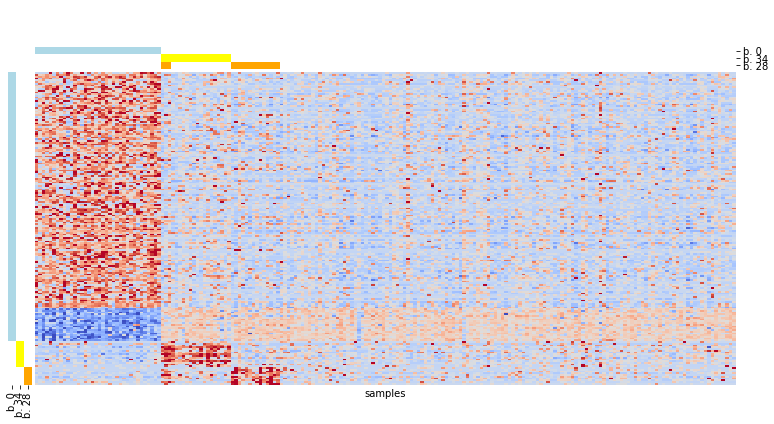

In [17]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import zscore

# select several biclusters to plot
# Basal: 0,lightblue; Her2+: 34,yellow; Neuroendocrine: 28,orange
i = [0,34,28] 
b = consensus_biclusters.loc[i,:]


tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors=["lightblue","yellow","orange"], # "auto",
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = False,
                no_row_colors = False,cluster_rows=False
             )